In [63]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [64]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import desc
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [66]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [67]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [68]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [69]:
# Retrieve column information using the inspector for measurement
inspector = inspect(engine)
inspector.get_table_names()
measurement_col = inspector.get_columns('measurement')
for column in measurement_col:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [70]:
# Retrieve column information using the inspector for station
station_col = inspector.get_columns('station')
for column in station_col:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [71]:
# To see the columns and data in the tables
measurement_col = pd.read_sql("SELECT * FROM measurement", conn)
station_col = pd.read_sql("SELECT * FROM station", conn)

In [72]:
measurement_col.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [73]:
station_col.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [74]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [75]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [76]:
# Find the most recent date in the data set.
dates = session.query(Measurement).order_by(desc(Measurement.date)).first()
print(f'The most recent date in the data set is: {dates.date}.')

The most recent date in the data set is: 2017-08-23.


The date one year from the last date in data set is: 2016-08-23


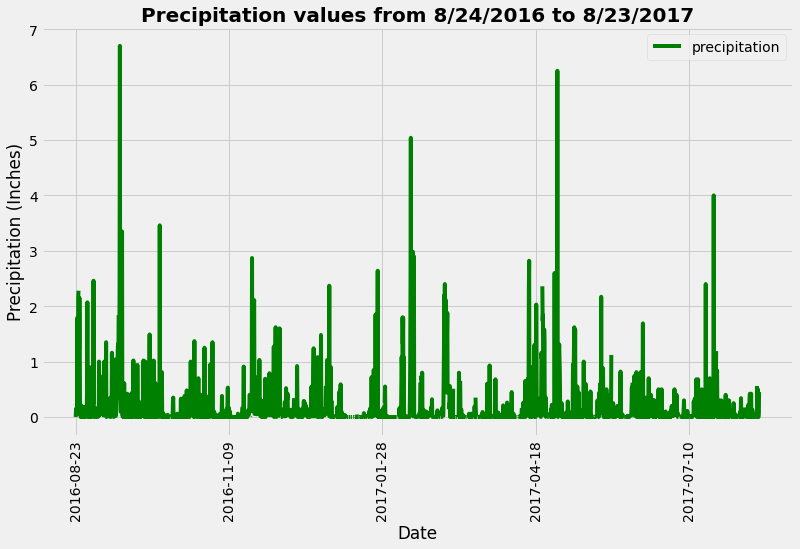

In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
print(f'The date one year from the last date in data set is: 2016-08-23')

# Perform a query to retrieve the data and precipitation scores
last_12months_precipitation = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).filter(Measurement.date>= '2016-08-23').all()
last_12months_precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(last_12months_precipitation, columns=['date', 'precipitation'])
rain_df.set_index('date', inplace=True)
# Sort the dataframe by date
rain_df.sort_index(inplace=True, ascending = True)
rain_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(kind='line', grid=True, figsize = (12,7), color = "green", rot = 90)
plt.title("Precipitation values from 8/24/2016 to 8/23/2017", fontsize = 20, fontweight = 'bold')
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")     
plt.savefig("images/Year_prp.png")


In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [79]:
# Design a query to calculate the total number stations in the dataset
total_number_stations = session.query(Station.station).group_by(Station.station).count()
print(f'The total number of stations in the dataset are: {total_number_stations}')

The total number of stations in the dataset are: 9


In [80]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [81]:
# The most active station
print(f'The most active station is: USC00519281')

The most active station is: USC00519281


In [82]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_USC_00519281 = session.query(Measurement.station, func.avg(Measurement.tobs), func.max(Measurement.tobs), func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
most_active_station_USC_00519281

[('USC00519281', 71.66378066378067, 85.0, 54.0)]

In [83]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram 
ma_station = session.query(Measurement.date).filter(Measurement.station == "USC00519281").order_by(desc(Measurement.date)).first()
print(f'The latest observation for station USC00519281 was on: {ma_station.date}.')

The latest observation for station USC00519281 was on: 2017-08-18.


In [84]:
Year_tempma = session.query(Measurement).filter(Measurement.station == "USC00519281").filter(Measurement.date > "2016-08-18").statement
temp_df = pd.read_sql_query(Year_tempma, session.bind)
temp_df.head()

,id,station,date,prcp,tobs
0,14604,USC00519281,2016-08-19,0.31,79.0
1,14605,USC00519281,2016-08-20,0.13,81.0
2,14606,USC00519281,2016-08-21,0.08,79.0
3,14607,USC00519281,2016-08-22,2.32,78.0
4,14608,USC00519281,2016-08-23,1.79,77.0


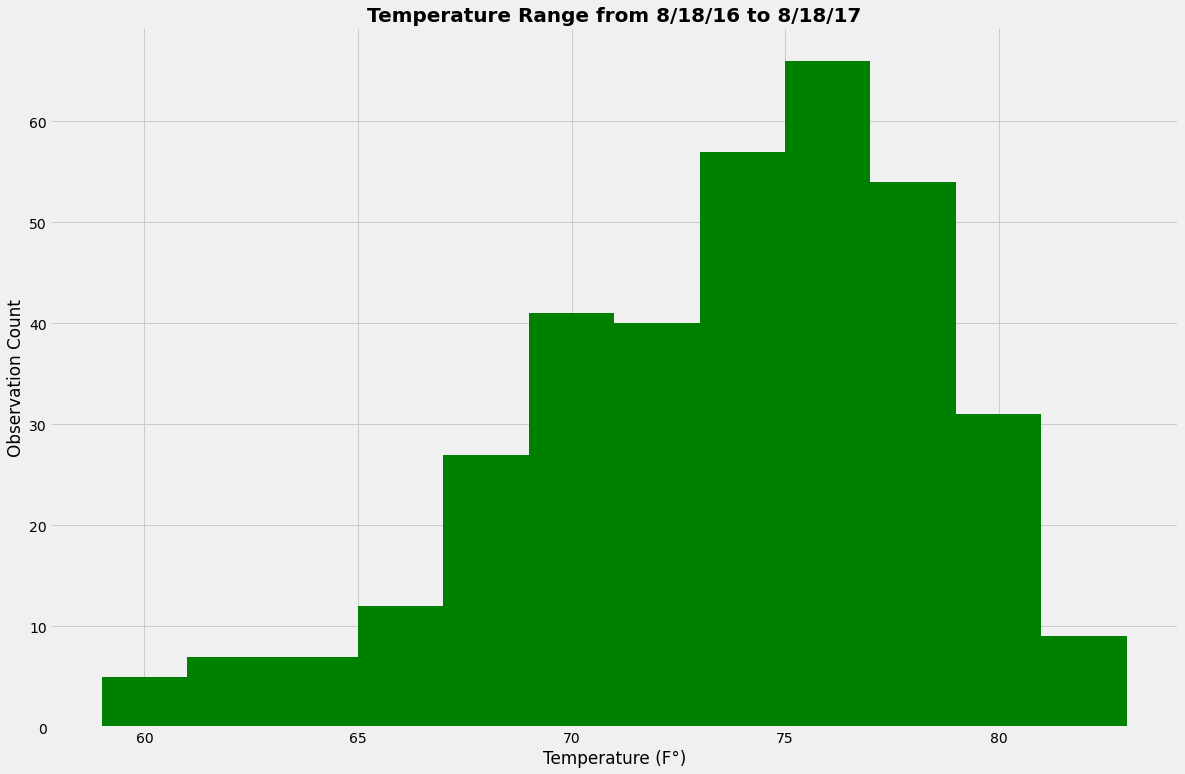

In [85]:
#Create the histogram 
temp = temp_df["tobs"]
temp.hist(bins=12, grid=True, figsize=(18,12), color = "green")
plt.xlabel("Temperature (F°)")
plt.ylabel("Observation Count")
plt.title("Temperature Range from 8/18/16 to 8/18/17", fontweight = "bold", fontsize = 20)
plt.savefig("Images/Temp.png")

# Close session

In [86]:
# Close Session
session.close()